# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import torch
from torch import nn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 2. Load Data

In [3]:
data = pd.read_csv('../data/nuts.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 3. Load Models

In [4]:
nb_model = joblib.load('../models/naive_bayes_model.pkl')
dt_model = joblib.load('../models/decision_tree_model.pkl')
rf_model = joblib.load('../models/random_forest_model.pkl')
svm_model = joblib.load('../models/svm_model.pkl')
knn_model = joblib.load('../models/knn_model.pkl')

class NutClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NutClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = len(np.unique(y))
model = NutClassifier(input_size=X_train.shape[1], num_classes=num_classes)
model.load_state_dict(torch.load('../models/nut_classifier_weights.pth'))
model.eval()


C:\Users\K0NQ\AppData\Local\Temp\ipykernel_33360\1846003815.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/nut_classifier_w

NutClassifier(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

# 4. Evaluate Models

In [5]:
models = {
    'Naive Bayes': nb_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'SVM': svm_model,
    'k-NN': knn_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {'confusion_matrix': cm, 'classification_report': cr}

# Evaluate Neural Network
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(np.unique(y))
model = NutClassifier(input_size=X_train.shape[1], num_classes=num_classes)
model.load_state_dict(torch.load('../models/nut_classifier_weights.pth'))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds, output_dict=True)
results['Neural Network'] = {'confusion_matrix': cm, 'classification_report': cr}


C:\Users\K0NQ\AppData\Local\Temp\ipykernel_33360\133687028.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/nut_classifier_we

# 5. Visualize Results

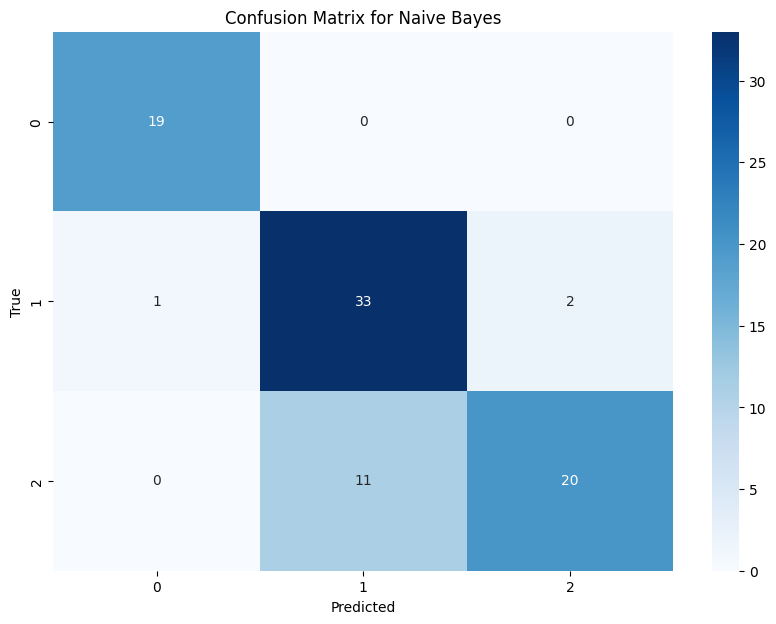

Classification Report for Naive Bayes:
              precision    recall  f1-score    support
0              0.950000  1.000000  0.974359  19.000000
1              0.750000  0.916667  0.825000  36.000000
2              0.909091  0.645161  0.754717  31.000000
accuracy       0.837209  0.837209  0.837209   0.837209
macro avg      0.869697  0.853943  0.851359  86.000000
weighted avg   0.851533  0.837209  0.832663  86.000000


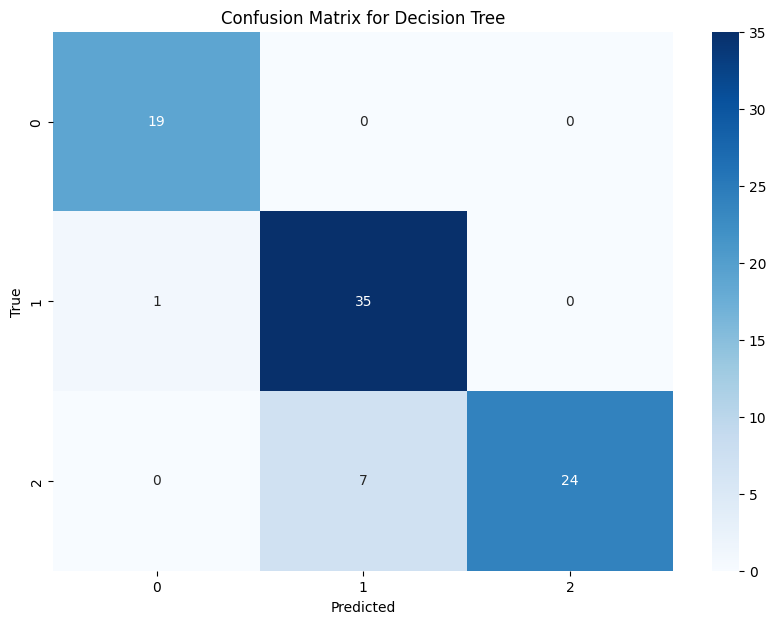

Classification Report for Decision Tree:
              precision    recall  f1-score    support
0              0.950000  1.000000  0.974359  19.000000
1              0.833333  0.972222  0.897436  36.000000
2              1.000000  0.774194  0.872727  31.000000
accuracy       0.906977  0.906977  0.906977   0.906977
macro avg      0.927778  0.915472  0.914841  86.000000
weighted avg   0.919186  0.906977  0.905524  86.000000


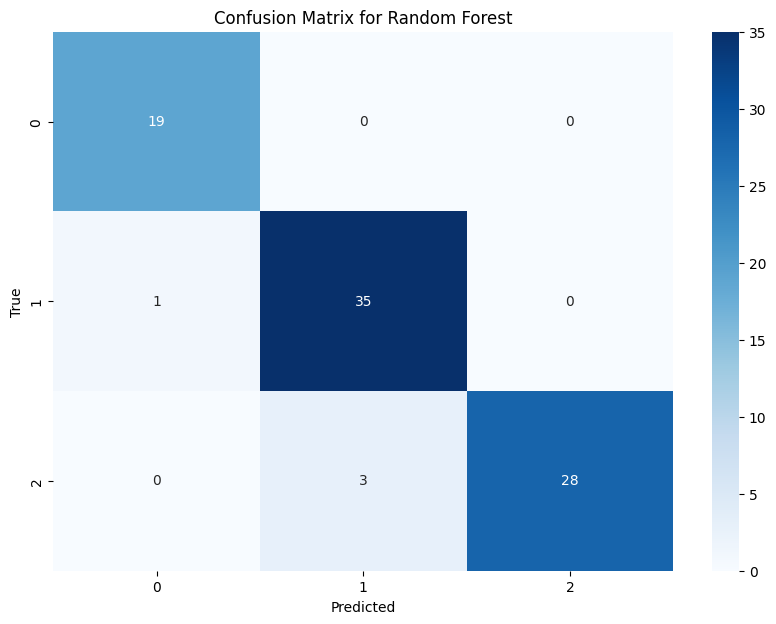

Classification Report for Random Forest:
              precision    recall  f1-score    support
0              0.950000  1.000000  0.974359  19.000000
1              0.921053  0.972222  0.945946  36.000000
2              1.000000  0.903226  0.949153  31.000000
accuracy       0.953488  0.953488  0.953488   0.953488
macro avg      0.957018  0.958483  0.956486  86.000000
weighted avg   0.955906  0.953488  0.953379  86.000000


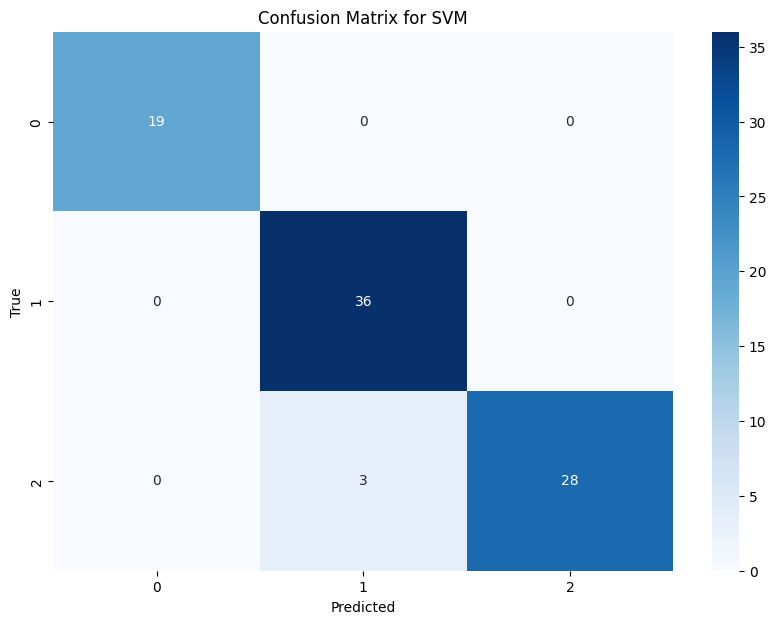

Classification Report for SVM:
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  19.000000
1              0.923077  1.000000  0.960000  36.000000
2              1.000000  0.903226  0.949153  31.000000
accuracy       0.965116  0.965116  0.965116   0.965116
macro avg      0.974359  0.967742  0.969718  86.000000
weighted avg   0.967800  0.965116  0.964927  86.000000


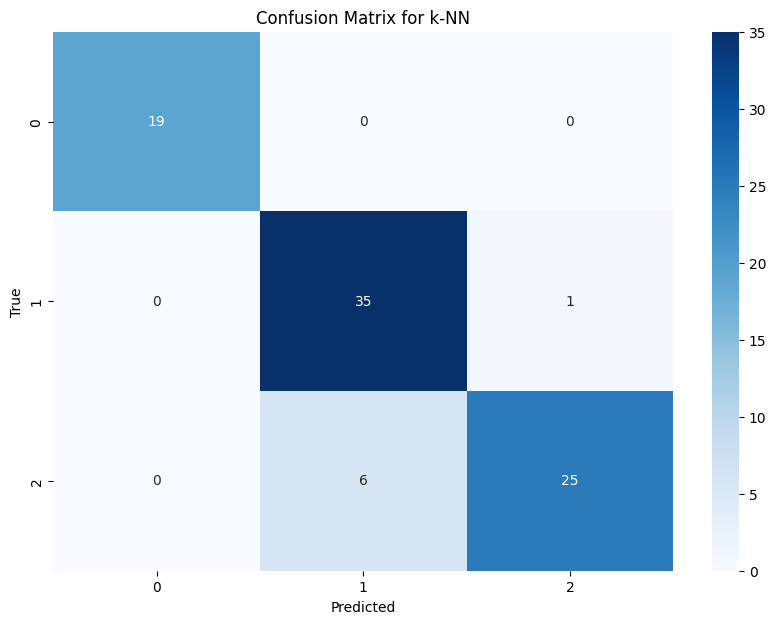

Classification Report for k-NN:
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  19.000000
1              0.853659  0.972222  0.909091  36.000000
2              0.961538  0.806452  0.877193  31.000000
accuracy       0.918605  0.918605  0.918605   0.918605
macro avg      0.938399  0.926225  0.928761  86.000000
weighted avg   0.924877  0.918605  0.917677  86.000000


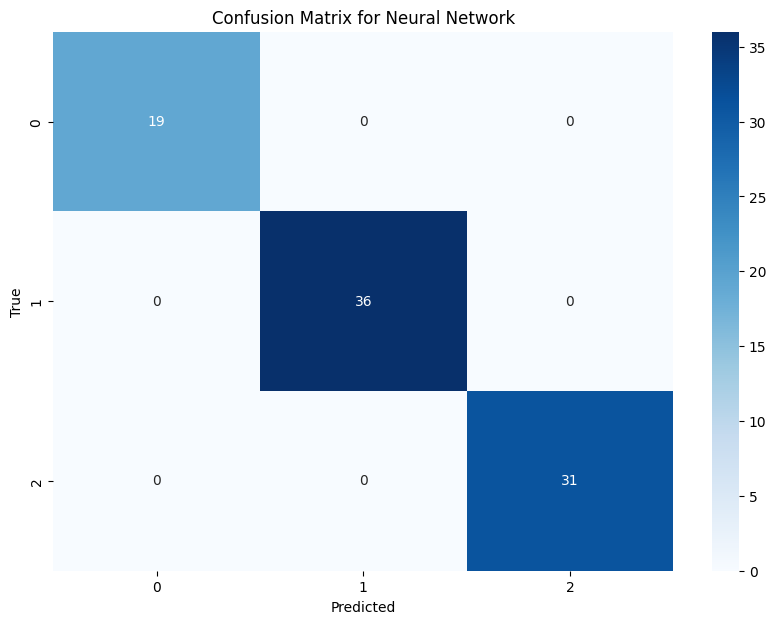

Classification Report for Neural Network:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     19.0
1                   1.0     1.0       1.0     36.0
2                   1.0     1.0       1.0     31.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     86.0
weighted avg        1.0     1.0       1.0     86.0


In [6]:
for name, result in results.items():
    cm = result['confusion_matrix']
    cr = result['classification_report']
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(f'Classification Report for {name}:')
    print(pd.DataFrame(cr).transpose())


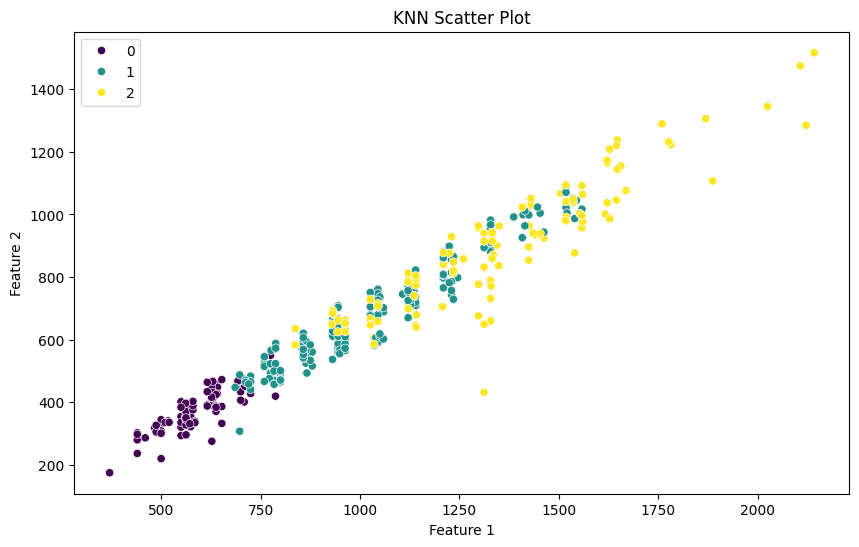

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already trained your models and have predictions
# ...existing code...

# Function to plot scatter plot for KNN
def plot_knn(X, y, model):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis')
    plt.title('KNN Scatter Plot')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Function to plot decision boundaries for other models
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=20)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Select 2-3 attributes that are the greatest predictors
# Assuming X is your feature matrix and y is your target variable
# Select the second to last and fourth to last columns
X_selected = X[:, [5, 9]]

# Plot for KNN
plot_knn(X_selected, y, knn_model)
